# Proyecto Final Statistical Learning 1
## Pronóstico de sobrevivencia al hundimiento del Titanic

### Parte 1 - Entrenamiento, Validación y Selección

In [1]:
import tensorflow as tf
from tensorflow import keras


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import tensorboard_logger as tl

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale

#from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from joblib import dump
#import datetime
from tensorboard_logger import configure, log_value

import datetime, os
import scipy
import seaborn as sns
#%load_ext tensorboard

In [2]:
#pip install tensorboard_logger

In [3]:
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Instructions for updating:
non-resource variables are not supported in the long term
Enabled compatitility to tf1.x


## Carga del dataset

In [4]:
data = pd.read_csv('data_titanic_proyecto.csv')

## Análisis Exploratorio

In [5]:
data.head(10)

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
0,1,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,Lower,M,N
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,Upper,F,Y
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Lower,F,Y
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,Upper,F,Y
4,5,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,Lower,M,N
5,6,"Moran, Mr. James",NaN,0,0,330877,8.4583,NaN,Q,Lower,M,N
6,7,"McCarthy, Mr. Timothy J",54.0,0,0,17463,51.8625,E46,S,Upper,M,N
7,8,"Palsson, Master. Gosta Leonard",2.0,3,1,349909,21.0750,NaN,S,Lower,M,N
8,9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.0,0,2,347742,11.1333,NaN,S,Lower,F,Y
9,10,"Nasser, Mrs. Nicholas (Adele Achem)",14.0,1,0,237736,30.0708,NaN,C,Middle,F,Y


In [6]:
data.describe()

,PassengerId,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,29.699118,0.523008,0.381594,32.204208
std,257.353842,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,38.000000,1.000000,0.000000,31.000000
max,891.000000,80.000000,8.000000,6.000000,512.329200


### Columnas con datos incompletos

In [7]:
total = data.isnull().sum().sort_values(ascending=False)
percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(8)

,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
passenger_survived,0,0.0
passenger_sex,0,0.0
passenger_class,0,0.0
Fare,0,0.0
Ticket,0,0.0


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PassengerId         891 non-null    int64  
 1   Name                891 non-null    object 
 2   Age                 714 non-null    float64
 3   SibSp               891 non-null    int64  
 4   Parch               891 non-null    int64  
 5   Ticket              891 non-null    object 
 6   Fare                891 non-null    float64
 7   Cabin               204 non-null    object 
 8   Embarked            889 non-null    object 
 9   passenger_class     891 non-null    object 
 10  passenger_sex       891 non-null    object 
 11  passenger_survived  891 non-null    object 
dtypes: float64(2), int64(3), object(7)
memory usage: 83.7+ KB


Datos faltantes en columnas ***Age, Cabin y Embarked***

### Diccionario

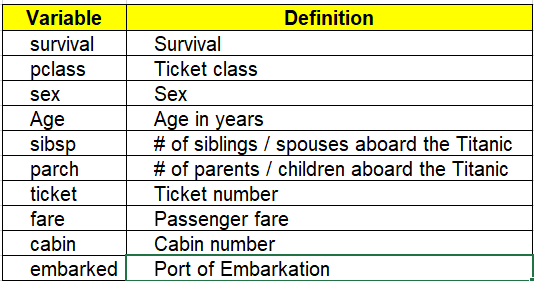

### Columnas Numéricas

<AxesSubplot:xlabel='Age', ylabel='Density'>

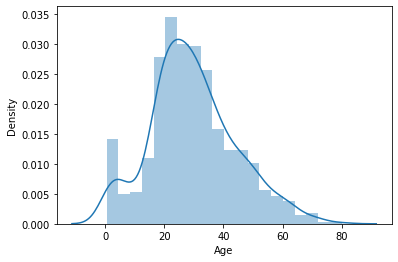

In [9]:
# desactiva mensajes futureWarnings
warnings.filterwarnings("ignore")
plt.figure()
sns.distplot(data['Age'])

<AxesSubplot:xlabel='SibSp', ylabel='Density'>

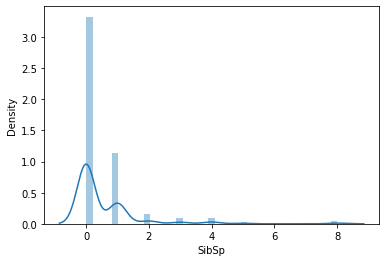

In [10]:
# No. of siblings / spouses aboard the Titanic
plt.figure()
sns.distplot(data['SibSp'])

<AxesSubplot:xlabel='Parch', ylabel='Density'>

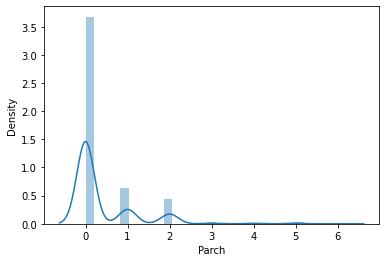

In [11]:
# No. of parents / children aboard the Titanic
plt.figure()
sns.distplot(data['Parch'])

<AxesSubplot:xlabel='Fare', ylabel='Density'>

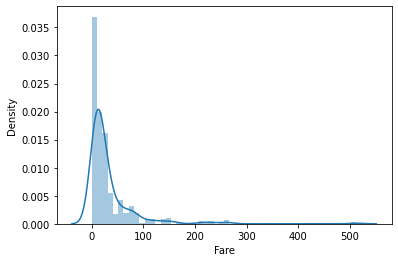

In [12]:
# Passenger fare
plt.figure()
sns.distplot(data['Fare'])

## Transformación de features 

In [13]:
onehot_class = np.array(data['passenger_class']).reshape(-1,1)

enc_train = OneHotEncoder(categories='auto')
enc_train.fit(onehot_class)
onehot_class = enc_train.transform(onehot_class).toarray()
data['Low_class'], data['Mid_class'], data['Upp_class'] = [onehot_class.T[0], onehot_class.T[1], onehot_class.T[2]]

In [14]:
data['passenger_sex'] = data['passenger_sex'].replace('M',1)
data['passenger_sex'] = data['passenger_sex'].replace('F',0)
data['passenger_sex'].head()

0    1
1    0
2    0
3    0
4    1
Name: passenger_sex, dtype: int64

In [15]:
data['passenger_survived'] = data['passenger_survived'].replace('Y',1)
data['passenger_survived'] = data['passenger_survived'].replace('N',0)
data['passenger_survived'].head()

0    0
1    1
2    1
3    1
4    0
Name: passenger_survived, dtype: int64

In [16]:
data = data.dropna(subset = ['Embarked'])

onehot_embarked = np.array(data['Embarked']).reshape(-1,1)
enc_train = OneHotEncoder(categories='auto')
enc_train.fit(onehot_embarked)
onehot_embarked = enc_train.transform(onehot_embarked).toarray()
data['Emb_C'], data['Emb_Q'], data['Emb_S'] = [onehot_embarked.T[0], onehot_embarked.T[1], onehot_embarked.T[2]]

In [17]:
data_clean = data.drop(columns = ['Embarked', 'passenger_class', 'Ticket', 'Name', 'Cabin', 'PassengerId'])
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 712 non-null    float64
 1   SibSp               889 non-null    int64  
 2   Parch               889 non-null    int64  
 3   Fare                889 non-null    float64
 4   passenger_sex       889 non-null    int64  
 5   passenger_survived  889 non-null    int64  
 6   Low_class           889 non-null    float64
 7   Mid_class           889 non-null    float64
 8   Upp_class           889 non-null    float64
 9   Emb_C               889 non-null    float64
 10  Emb_Q               889 non-null    float64
 11  Emb_S               889 non-null    float64
dtypes: float64(8), int64(4)
memory usage: 90.3 KB


In [18]:
data_clean['Age'].fillna(int(data_clean['Age'].mean()), inplace=True)

In [19]:
data_clean

,Age,SibSp,Parch,Fare,passenger_sex,passenger_survived,Low_class,Mid_class,Upp_class,Emb_C,Emb_Q,Emb_S
0,22.0,1,0,7.2500,1,0,1.0,0.0,0.0,0.0,0.0,1.0
1,38.0,1,0,71.2833,0,1,0.0,0.0,1.0,1.0,0.0,0.0
2,26.0,0,0,7.9250,0,1,1.0,0.0,0.0,0.0,0.0,1.0
3,35.0,1,0,53.1000,0,1,0.0,0.0,1.0,0.0,0.0,1.0
4,35.0,0,0,8.0500,1,0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,1,0,0.0,1.0,0.0,0.0,0.0,1.0
887,19.0,0,0,30.0000,0,1,0.0,0.0,1.0,0.0,0.0,1.0
888,29.0,1,2,23.4500,0,0,1.0,0.0,0.0,0.0,0.0,1.0
889,26.0,0,0,30.0000,1,1,0.0,0.0,1.0,1.0,0.0,0.0


In [20]:
data_clean['MiembrosFam'] = data_clean['SibSp'] + data_clean['Parch']

In [21]:
data_clean

,Age,SibSp,Parch,Fare,passenger_sex,passenger_survived,Low_class,Mid_class,Upp_class,Emb_C,Emb_Q,Emb_S,MiembrosFam
0,22.0,1,0,7.2500,1,0,1.0,0.0,0.0,0.0,0.0,1.0,1
1,38.0,1,0,71.2833,0,1,0.0,0.0,1.0,1.0,0.0,0.0,1
2,26.0,0,0,7.9250,0,1,1.0,0.0,0.0,0.0,0.0,1.0,0
3,35.0,1,0,53.1000,0,1,0.0,0.0,1.0,0.0,0.0,1.0,1
4,35.0,0,0,8.0500,1,0,1.0,0.0,0.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,13.0000,1,0,0.0,1.0,0.0,0.0,0.0,1.0,0
887,19.0,0,0,30.0000,0,1,0.0,0.0,1.0,0.0,0.0,1.0,0
888,29.0,1,2,23.4500,0,0,1.0,0.0,0.0,0.0,0.0,1.0,3
889,26.0,0,0,30.0000,1,1,0.0,0.0,1.0,1.0,0.0,0.0,0


In [22]:
# Volvemos a revisar si hay datos incompletos en las columnas del dataframe depurado
total = data_clean.isnull().sum().sort_values(ascending=False)
percent_1 = data_clean.isnull().sum()/data_clean.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total', '%'])
missing_data.head(8)

,Total,%
MiembrosFam,0,0.0
Emb_S,0,0.0
Emb_Q,0,0.0
Emb_C,0,0.0
Upp_class,0,0.0
Mid_class,0,0.0
Low_class,0,0.0
passenger_survived,0,0.0


### Estandarización de valores de columnas que no son de Característica

In [23]:
data_clean[['Age','SibSp','Parch','Fare','MiembrosFam']] = normalize(data_clean[['Age','SibSp','Parch','Fare','MiembrosFam']])

In [24]:
ys = data_clean['passenger_survived']
ys

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: passenger_survived, Length: 889, dtype: int64

In [25]:
#x_train = data_clean.drop(columns=['passenger_survived'])
xs = data_clean.drop('passenger_survived', axis=1)
xs

,Age,SibSp,Parch,Fare,passenger_sex,Low_class,Mid_class,Upp_class,Emb_C,Emb_Q,Emb_S,MiembrosFam
0,0.947992,0.043091,0.000000,0.312406,1,1.0,0.0,0.0,0.0,0.0,1.0,0.043091
1,0.470345,0.012377,0.000000,0.882309,0,0.0,0.0,1.0,1.0,0.0,0.0,0.012377
2,0.956551,0.000000,0.000000,0.291564,0,1.0,0.0,0.0,0.0,0.0,1.0,0.000000
3,0.550202,0.015720,0.000000,0.834735,0,0.0,0.0,1.0,0.0,0.0,1.0,0.015720
4,0.974555,0.000000,0.000000,0.224148,1,1.0,0.0,0.0,0.0,0.0,1.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.901002,0.000000,0.000000,0.433816,1,0.0,1.0,0.0,0.0,0.0,1.0,0.000000
887,0.535052,0.000000,0.000000,0.844819,0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000
888,0.773704,0.026679,0.053359,0.625633,0,1.0,0.0,0.0,0.0,0.0,1.0,0.080038
889,0.654931,0.000000,0.000000,0.755689,1,0.0,0.0,1.0,1.0,0.0,0.0,0.000000


## Separación del Set de Datos para Entrenamiento, Pruebas y Validación

In [26]:
x_train, x_test, y_train, y_test = train_test_split(xs, ys, test_size=0.20, random_state=109)

In [27]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.20, random_state=109)

In [28]:
print("Sizes of Train ",x_train.shape, " Test ",x_test.shape, " Validation ", x_val.shape)

Sizes of Train  (568, 12)  Test  (178, 12)  Validation  (143, 12)


### Genera archivos deploy

In [29]:
dump(x_test,'xTestDeploy.joblib')
dump(y_test,'yTestDeploy.joblib')

['yTestDeploy.joblib']

## Clasificación

### Árbol de decisión con sklearn

In [33]:
def f_trainDecisionTree(p_max_depth = None, p_min_samples_split = 2, p_min_samples_leaf = 1):
    
    fstring = './experimentos/'+"arbolDecision"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_maxdepth=" + str(p_max_depth) \
    + "_minsamplesplit=" + str(p_min_samples_split) + "_minsampleleaf=" + str(p_min_samples_leaf)

    #tl.configure(fstring) 
    tlogs = tl.Logger(fstring)
    decision_tree = DecisionTreeClassifier(max_depth = p_max_depth, min_samples_split = p_min_samples_split, min_samples_leaf = p_min_samples_leaf)

    decision_tree.fit(x_train, y_train)
    
    # Train accuracy
    train_accuracy = decision_tree.score(x_train, y_train)
    tlogs.log_value('train_accuracy', train_accuracy, 1)

    # Validate accuracy
    val_accuracy = decision_tree.score(x_val, y_val)
    tlogs.log_value('val_accuracy', val_accuracy, 1)
    
    Y_pred = decision_tree.predict(x_val)
    
    print(classification_report(Y_pred, y_val))
    
    print("training accuracy:", train_accuracy)
    print("validate accuracy:", val_accuracy)
    print("---------------------------------------------------")
    
    return decision_tree


### Entrenamientos

In [31]:
f_trainDecisionTree(p_max_depth = 10, p_min_samples_split = 2, p_min_samples_leaf = 1)

              precision    recall  f1-score   support

           0       0.83      0.81      0.82        91
           1       0.69      0.71      0.70        52

    accuracy                           0.78       143
   macro avg       0.76      0.76      0.76       143
weighted avg       0.78      0.78      0.78       143

training accuracy: 0.9295774647887324
validate accuracy: 0.7762237762237763
---------------------------------------------------


DecisionTreeClassifier(max_depth=10)

In [34]:
f_trainDecisionTree(p_max_depth = 7, p_min_samples_split = 2, p_min_samples_leaf = 1)

              precision    recall  f1-score   support

           0       0.88      0.79      0.83        99
           1       0.61      0.75      0.67        44

    accuracy                           0.78       143
   macro avg       0.74      0.77      0.75       143
weighted avg       0.79      0.78      0.78       143

training accuracy: 0.8996478873239436
validate accuracy: 0.7762237762237763
---------------------------------------------------


DecisionTreeClassifier(max_depth=7)

In [35]:
f_trainDecisionTree(p_max_depth = 5, p_min_samples_split = 2, p_min_samples_leaf = 1)

              precision    recall  f1-score   support

           0       0.89      0.81      0.84        98
           1       0.65      0.78      0.71        45

    accuracy                           0.80       143
   macro avg       0.77      0.79      0.78       143
weighted avg       0.81      0.80      0.80       143

training accuracy: 0.8609154929577465
validate accuracy: 0.7972027972027972
---------------------------------------------------


DecisionTreeClassifier(max_depth=5)

In [36]:
f_trainDecisionTree(p_max_depth = 3, p_min_samples_split = 2, p_min_samples_leaf = 1)

              precision    recall  f1-score   support

           0       0.97      0.79      0.87       109
           1       0.57      0.91      0.70        34

    accuracy                           0.82       143
   macro avg       0.77      0.85      0.79       143
weighted avg       0.87      0.82      0.83       143

training accuracy: 0.8257042253521126
validate accuracy: 0.8181818181818182
---------------------------------------------------


DecisionTreeClassifier(max_depth=3)

In [37]:
f_trainDecisionTree(p_max_depth = 3, p_min_samples_split = 3, p_min_samples_leaf = 1)

              precision    recall  f1-score   support

           0       0.93      0.79      0.86       105
           1       0.59      0.84      0.70        38

    accuracy                           0.80       143
   macro avg       0.76      0.82      0.78       143
weighted avg       0.84      0.80      0.81       143

training accuracy: 0.8257042253521126
validate accuracy: 0.8041958041958042
---------------------------------------------------


DecisionTreeClassifier(max_depth=3, min_samples_split=3)

In [38]:
f_trainDecisionTree(p_max_depth = 4, p_min_samples_split = 2, p_min_samples_leaf = 1)

              precision    recall  f1-score   support

           0       0.92      0.80      0.85       103
           1       0.61      0.82      0.70        40

    accuracy                           0.80       143
   macro avg       0.77      0.81      0.78       143
weighted avg       0.83      0.80      0.81       143

training accuracy: 0.8309859154929577
validate accuracy: 0.8041958041958042
---------------------------------------------------


DecisionTreeClassifier(max_depth=4)

In [39]:
f_trainDecisionTree(p_max_depth = 4, p_min_samples_split = 3, p_min_samples_leaf = 1)

              precision    recall  f1-score   support

           0       0.92      0.80      0.85       103
           1       0.61      0.82      0.70        40

    accuracy                           0.80       143
   macro avg       0.77      0.81      0.78       143
weighted avg       0.83      0.80      0.81       143

training accuracy: 0.8309859154929577
validate accuracy: 0.8041958041958042
---------------------------------------------------


DecisionTreeClassifier(max_depth=4, min_samples_split=3)

In [40]:
f_trainDecisionTree(p_max_depth = 4, p_min_samples_split = 4, p_min_samples_leaf = 1)

              precision    recall  f1-score   support

           0       0.93      0.81      0.86       103
           1       0.63      0.85      0.72        40

    accuracy                           0.82       143
   macro avg       0.78      0.83      0.79       143
weighted avg       0.85      0.82      0.83       143

training accuracy: 0.8362676056338029
validate accuracy: 0.8181818181818182
---------------------------------------------------


DecisionTreeClassifier(max_depth=4, min_samples_split=4)

In [41]:
f_trainDecisionTree(p_max_depth = 4, p_min_samples_split = 5, p_min_samples_leaf = 1)

              precision    recall  f1-score   support

           0       0.93      0.81      0.86       103
           1       0.63      0.85      0.72        40

    accuracy                           0.82       143
   macro avg       0.78      0.83      0.79       143
weighted avg       0.85      0.82      0.83       143

training accuracy: 0.8362676056338029
validate accuracy: 0.8181818181818182
---------------------------------------------------


DecisionTreeClassifier(max_depth=4, min_samples_split=5)

In [42]:
f_trainDecisionTree(p_max_depth = 10, p_min_samples_split = 2, p_min_samples_leaf = 2)

              precision    recall  f1-score   support

           0       0.91      0.77      0.84       105
           1       0.56      0.79      0.65        38

    accuracy                           0.78       143
   macro avg       0.73      0.78      0.74       143
weighted avg       0.82      0.78      0.79       143

training accuracy: 0.8943661971830986
validate accuracy: 0.7762237762237763
---------------------------------------------------


DecisionTreeClassifier(max_depth=10, min_samples_leaf=2)

In [43]:
f_trainDecisionTree(p_max_depth = 10, p_min_samples_split = 3, p_min_samples_leaf = 1)

              precision    recall  f1-score   support

           0       0.84      0.80      0.82        94
           1       0.65      0.71      0.68        49

    accuracy                           0.77       143
   macro avg       0.75      0.76      0.75       143
weighted avg       0.78      0.77      0.77       143

training accuracy: 0.9225352112676056
validate accuracy: 0.7692307692307693
---------------------------------------------------


DecisionTreeClassifier(max_depth=10, min_samples_split=3)

In [44]:
f_trainDecisionTree(p_max_depth = 10, p_min_samples_split = 4, p_min_samples_leaf = 1)

              precision    recall  f1-score   support

           0       0.82      0.82      0.82        89
           1       0.70      0.70      0.70        54

    accuracy                           0.78       143
   macro avg       0.76      0.76      0.76       143
weighted avg       0.78      0.78      0.78       143

training accuracy: 0.926056338028169
validate accuracy: 0.7762237762237763
---------------------------------------------------


DecisionTreeClassifier(max_depth=10, min_samples_split=4)

In [45]:
resultado_dt = f_trainDecisionTree(p_max_depth = 4, p_min_samples_split = 3, p_min_samples_leaf = 15)

              precision    recall  f1-score   support

           0       0.88      0.81      0.84        96
           1       0.67      0.77      0.71        47

    accuracy                           0.80       143
   macro avg       0.77      0.79      0.78       143
weighted avg       0.81      0.80      0.80       143

training accuracy: 0.8221830985915493
validate accuracy: 0.7972027972027972
---------------------------------------------------


In [46]:
dump(resultado_dt, "f_trainDecisionTree(max_depth = 4, min_samples_split = 3, min_samples_leaf = 15).joblib")

['f_trainDecisionTree(max_depth = 4, min_samples_split = 3, min_samples_leaf = 15).joblib']

In [47]:
resultado_dt

DecisionTreeClassifier(max_depth=4, min_samples_leaf=15, min_samples_split=3)

### SVM con sklearn

In [48]:
def f_trainSVM(p_C= 1.0, p_kernel = 'rbf'):
    ## rbf = radial basis function
    
    fstring = './experimentos/'+"SVM"+datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_C=" + str(p_C) + "_kernel=" + p_kernel
     
    #logs = tensorboard_logger.Logger(fstring)
    #tl.configure(fstring)
    tlogs = tl.Logger(fstring)
    
    modeloSvm = svm.SVC(C=p_C, kernel=p_kernel)
    modeloSvm.fit(x_train, y_train)
    
    # train accuracy
    train_accuracy = modeloSvm.score(x_train, y_train)
    tlogs.log_value('train_accuracy', train_accuracy, 1)

    # Validation accuracy
    val_accuracy = modeloSvm.score(x_val, y_val)
    tlogs.log_value('val_accuracy', val_accuracy, 1)
    
    #SVM_preditcions_val 
    Y_pred = modeloSvm.predict(x_val)
    
    print(classification_report(Y_pred, y_val))
    
    print("training accuracy:", train_accuracy)
    print("validate accuracy:", val_accuracy)
    print("---------------------------------------------------")
    
    return modeloSvm

### Entrenamientos

In [49]:
f_trainSVM(p_C = 1.0, p_kernel = 'rbf')

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       111
           1       0.54      0.91      0.67        32

    accuracy                           0.80       143
   macro avg       0.75      0.84      0.77       143
weighted avg       0.87      0.80      0.82       143

training accuracy: 0.8133802816901409
validate accuracy: 0.8041958041958042
---------------------------------------------------


SVC()

In [50]:
f_trainSVM(p_C = 10.0, p_kernel = 'rbf')

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       108
           1       0.54      0.83      0.65        35

    accuracy                           0.78       143
   macro avg       0.73      0.80      0.75       143
weighted avg       0.84      0.78      0.80       143

training accuracy: 0.8221830985915493
validate accuracy: 0.7832167832167832
---------------------------------------------------


SVC(C=10.0)

In [51]:
f_trainSVM(p_C = 5.0, p_kernel = 'rbf')

              precision    recall  f1-score   support

           0       0.93      0.77      0.84       108
           1       0.54      0.83      0.65        35

    accuracy                           0.78       143
   macro avg       0.73      0.80      0.75       143
weighted avg       0.84      0.78      0.80       143

training accuracy: 0.8221830985915493
validate accuracy: 0.7832167832167832
---------------------------------------------------


SVC(C=5.0)

In [52]:
f_trainSVM(p_C = 2.0, p_kernel = 'rbf')

              precision    recall  f1-score   support

           0       0.96      0.77      0.85       110
           1       0.54      0.88      0.67        33

    accuracy                           0.80       143
   macro avg       0.75      0.83      0.76       143
weighted avg       0.86      0.80      0.81       143

training accuracy: 0.8257042253521126
validate accuracy: 0.7972027972027972
---------------------------------------------------


SVC(C=2.0)

In [53]:
resultado_SVMClassifier = f_trainSVM(p_C = 1.0, p_kernel = 'rbf')

              precision    recall  f1-score   support

           0       0.97      0.77      0.86       111
           1       0.54      0.91      0.67        32

    accuracy                           0.80       143
   macro avg       0.75      0.84      0.77       143
weighted avg       0.87      0.80      0.82       143

training accuracy: 0.8133802816901409
validate accuracy: 0.8041958041958042
---------------------------------------------------


In [54]:
dump(resultado_SVMClassifier, "f_trainSVM(C = 1, kernel = 'rbf').joblib")

["f_trainSVM(C = 1, kernel = 'rbf').joblib"]

In [55]:
resultado_SVMClassifier

SVC()

## Regresión logística binaria(Sigmoid)  

In [56]:
y_train_reshaped = np.array(y_train).reshape(-1,1)
y_val_reshaped = np.array(y_val).reshape(-1,1)

print("y_train_reshaped ",y_train_reshaped.shape, "y_train_reshaped", y_train_reshaped.shape)

x_train_reshaped = np.insert(np.array(x_train),0, np.ones(len(x_train)), axis = 1)
x_val_reshaped = np.insert(np.array(x_val),0, np.ones(len(x_val)), axis = 1)

print("x_train_reshaped",x_train_reshaped.shape, "x_val_reshaped", x_val_reshaped.shape)


y_train_reshaped  (568, 1) y_train_reshaped (568, 1)
x_train_reshaped (568, 13) x_val_reshaped (143, 13)


In [57]:
class LogRegSigmoid:
    
    def __init__(self, x,  p_lambda, regularization):
        # vector de weights
        self.w = tf.get_variable("weights", dtype = tf.float32, shape = [1,x.shape[1]], initializer = tf.zeros_initializer())
        self.p_lambda = tf.constant(p_lambda, dtype = tf.float32)
        self.regularization = regularization
        
    # Funcion logits
    def logits(self, x):
        with tf.name_scope("logits"):
            return tf.matmul(x, tf.transpose(self.w))
 
    #Distribución de probabilidad
    def predictModel(self, x):
        sigmoid = tf.nn.sigmoid(self.logits(x))
        predictions = tf.round(sigmoid)
        return predictions
    
    # Obtiene la precisión
    def getAccuracy(self, y_hat, y):
        with tf.name_scope("accuracy"):
            accuracy = tf.equal(y_hat, y)
            accuracy = tf.cast(accuracy, tf.int32)
            accuracy = tf.divide(tf.reduce_sum(accuracy), tf.shape(y)[0])
            return accuracy 

        # obtiene el error
    def getLoss(self, x, y):
        entropia_cruz = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = self.logits(x)))
        
        if self.regularization == 'lasso':
            error = tf.add(entropia_cruz,tf.multiply(self.p_lambda, tf.reduce_sum(tf.abs(self.w))))
        if self.regularization == 'ridge':
            error = tf.add(entropia_cruz, tf.multiply(self.p_lambda, tf.sqrt(tf.reduce_sum(tf.square(self.w)))))
        return error
    
    def actualiza(self, x_train, y_train, x_test, y_test, learningrate):
        with tf.name_scope("error"):
            train_error = self.getLoss(x_train, y_train)
            train_error_summary = tf.summary.scalar("TrainError", train_error)
            
            test_error = self.getLoss(x_test, y_test)
            test_error_summary = tf.summary.scalar("ValError", test_error)
            
        with tf.name_scope("accuracy"):
            train_accuracy = self.getAccuracy(self.predictModel(x_train), y_train)
            train_accuracy_summary = tf.summary.scalar("TrainAccuracy", train_accuracy)
            
            test_accuracy = self.getAccuracy(self.predictModel(x_test), y_test)
            test_accuracy_summary = tf.summary.scalar("ValAccuracy", test_accuracy)
        
        # Actualiza los parámetros
        gradient = tf.gradients(train_error, [self.w])
        updated_w = tf.assign(self.w, self.w - learningrate * gradient[0])
        
        #return updated_w, train_error, train_accuracy
        
        return updated_w, train_error, test_error, train_accuracy, test_accuracy, train_error_summary, test_error_summary, train_accuracy_summary, test_accuracy_summary

In [58]:
def f_train_LogRegSigmoid(lr, epochs, p_visual, x_train, x_test, labels_train, labels_test, batch_size, p_lambda, p_regula):
    # String para definicion de experimento
    string = './experimentos/LogReg'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S") +"_lr="+str(lr)+ "_epochs="+str(epochs) + "_bs=" \
    + str(batch_size) + '_lambda=' + str(p_lambda) + "_regularization=" + p_regula

    g = tf.Graph()
    with g.as_default():
        # Inicialización de objeto de clase LogisticRegressionSoftmax
        modelo = LogRegSigmoid(x_train, p_lambda, p_regula)
        
        # Definicion de placeholders para input de data a grafo
        with tf.name_scope("train_tensors"):
            tensor_x_train = tf.placeholder(tf.float32, [None,x_train.shape[1]], "tensor_x_train")
            tensor_labels_train = tf.placeholder(tf.float32, [None,labels_train.shape[1]], "tensor_labels_train")
            
        with tf.name_scope("val_tensors"):
            tensor_x_test = tf.placeholder(tf.float32, [x_test.shape[0], x_test.shape[1]], "tensor_x_val")
            tensor_labels_test = tf.placeholder(tf.float32, [labels_test.shape[0], labels_test.shape[1]], "tensor_labels_val")
            
        # Utilizacion de método update para hacer el entrenamiento
        update_parameters = modelo.actualiza(tensor_x_train, tensor_labels_train, tensor_x_test, tensor_labels_test, lr)
    
        # Writer para utilizacion de tensorboard
        writer = tf.summary.FileWriter(string, g)
        
        total_steps = int((labels_train.shape[0] / batch_size) * epochs)  
        
        with tf.train.MonitoredSession() as session:
            
            for i in range(total_steps + 1):
                # Mini batch gradient descent with batch size 32
                offset = (i * batch_size) % (labels_train.shape[0] - batch_size)
                batch_data = x_train[offset:(offset + batch_size),]
                batch_labels = labels_train[offset:(offset + batch_size),]
                feed_dict = {tensor_x_train:batch_data, tensor_labels_train:batch_labels,tensor_x_test:x_test, tensor_labels_test:labels_test}
                # Entrenamiento
                training = session.run(update_parameters, feed_dict = feed_dict)
                if (i)%p_visual == 0:
                    # Cálculo de pesos para print por cada frecprint epocas
                    weights = session.run(modelo.w, feed_dict = feed_dict)
                    # Agregar datos a writer para poder visualizarlos en tensorboard
                    writer.add_summary(training[5], i)
                    writer.add_summary(training[6], i)
                    writer.add_summary(training[7], i)
                    writer.add_summary(training[8], i)
                    print("Batch step:", i, "train error:", training[1], "train accuracy:", training[3])
                    print("Epoch:", int(i//(labels_train.shape[0] / batch_size)+1), "validation error:", training[2], "validation accuracy:", training[4])
                    print("-------------------------------------------------------------------------")
            
            return weights

            writer.close()

### Entrenamientos

In [59]:
#f_train_LogRegSigmoid(lr, epochs, p_visual, x_train, x_test, labels_train, labels_test, batch_size, p_lambda, p_regulariza):
f_train_LogRegSigmoid(0.01, 1000, 1000, x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped, 32, 0, 'lasso')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Batch step: 0 train error: 0.6931472 train accuracy: 0.53125
Epoch: 1 validation error: 0.69314736 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch step: 1000 train error: 0.552972 train accuracy: 0.75
Epoch: 57 validation error: 0.53791684 validation accuracy: 0.7622377622377622
-------------------------------------------------------------------------
Batch step: 2000 train error: 0.40579835 train accuracy: 0.90625
Epoch: 113 validation error: 0.5066307 validation accuracy: 0.7622377622377622
-------------------------------------------------------------------------
Batch step: 3000 train error: 0.502737 train accuracy: 0.8125
Epoch: 170 validation error: 0.49402928 validation accuracy: 0.7762237762237763
-------------------------------------------------------------------------
Batch step: 4000 tra

array([[ 0.700467  , -0.2698397 , -0.07522886,  0.02277292,  1.0140586 ,
        -2.549012  , -0.6322292 ,  0.5997151 ,  0.73297757,  0.4481191 ,
         0.46129137, -0.20893964, -0.05245626]], dtype=float32)

In [60]:
f_train_LogRegSigmoid(0.01, 1000, 1000, x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped, 32, 0.5, 'lasso')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Batch step: 0 train error: 0.6931472 train accuracy: 0.53125
Epoch: 1 validation error: 0.69314736 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch step: 1000 train error: 0.71135324 train accuracy: 0.5
Epoch: 57 validation error: 0.71070683 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch step: 2000 train error: 0.70765924 train accuracy: 0.21875
Epoch: 113 validation error: 0.70730984 validation accuracy: 0.32167832167832167
-------------------------------------------------------------------------
Batch step: 3000 train error: 0.7087392 train accuracy: 0.65625
Epoch: 170 validation error: 0.70915675 validation accuracy: 0.6363636363636364
-------------------------------------------------------------------------
Batch step: 400

array([[-0.0037081 , -0.00012666,  0.00102608, -0.00241592,  0.00320155,
        -0.00564744, -0.00154544, -0.00054401, -0.00161868,  0.00431456,
         0.00029065,  0.00168662, -0.00138982]], dtype=float32)

In [61]:
f_train_LogRegSigmoid(0.01, 1000, 1000, x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped, 32, 0.05, 'lasso')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Batch step: 0 train error: 0.6931472 train accuracy: 0.53125
Epoch: 1 validation error: 0.69314736 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch step: 1000 train error: 0.65347296 train accuracy: 0.78125
Epoch: 57 validation error: 0.63306075 validation accuracy: 0.7552447552447552
-------------------------------------------------------------------------
Batch step: 2000 train error: 0.567364 train accuracy: 0.875
Epoch: 113 validation error: 0.62702924 validation accuracy: 0.7552447552447552
-------------------------------------------------------------------------
Batch step: 3000 train error: 0.60855573 train accuracy: 0.8125
Epoch: 170 validation error: 0.62371576 validation accuracy: 0.7552447552447552
-------------------------------------------------------------------------
Batch step: 4000

array([[-6.9022458e-04, -4.4347334e-04,  3.5072971e-04,  8.9695008e-05,
         2.3810703e-01, -1.1550452e+00, -2.3834887e-03,  7.3406770e-04,
         1.2295967e-01, -4.9558276e-04, -4.1977721e-05, -1.5272660e-04,
         4.4042143e-04]], dtype=float32)

In [62]:
#f_train_LogRegSigmoid(lr, epochs, frecprint, x_train, x_test, labels_train, labels_test, batch_size, p_lambda, p_regulariza):
f_train_LogRegSigmoid(0.001, 1000, 1000, x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped, 32, 0, 'lasso')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Batch step: 0 train error: 0.6931472 train accuracy: 0.53125
Epoch: 1 validation error: 0.69314736 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch step: 1000 train error: 0.66223073 train accuracy: 0.5
Epoch: 57 validation error: 0.6373795 validation accuracy: 0.6363636363636364
-------------------------------------------------------------------------
Batch step: 2000 train error: 0.5527469 train accuracy: 0.78125
Epoch: 113 validation error: 0.61260086 validation accuracy: 0.6643356643356644
-------------------------------------------------------------------------
Batch step: 3000 train error: 0.5797472 train accuracy: 0.75
Epoch: 170 validation error: 0.5963649 validation accuracy: 0.6993006993006993
-------------------------------------------------------------------------
Batch step: 4000 train

array([[ 2.4644367e-01, -2.3225136e-01,  1.1469810e-03,  1.6568821e-02,
         5.5982685e-01, -1.2791573e+00, -4.8314050e-01,  2.7475747e-01,
         4.5482808e-01,  2.6194021e-01,  1.1831223e-01, -1.3380831e-01,
         1.7715821e-02]], dtype=float32)

In [63]:
f_train_LogRegSigmoid(0.01, 10000, 10000, x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped, 32, 0.10, 'lasso')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Batch step: 0 train error: 0.6931472 train accuracy: 0.53125
Epoch: 1 validation error: 0.69314736 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch step: 10000 train error: 0.69175184 train accuracy: 0.46875
Epoch: 564 validation error: 0.66199905 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch step: 20000 train error: 0.6883253 train accuracy: 0.4375
Epoch: 1127 validation error: 0.66191643 validation accuracy: 0.6293706293706294
-------------------------------------------------------------------------
Batch step: 30000 train error: 0.70484126 train accuracy: 0.4375
Epoch: 1691 validation error: 0.66187215 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch st

array([[ 8.8790967e-04,  5.1621289e-04, -2.4746166e-04,  1.6288646e-04,
         3.5619072e-04, -6.2677336e-01, -8.7885879e-04,  1.4108082e-04,
         1.6255553e-03,  7.6016545e-04, -2.9875315e-05,  1.5729578e-04,
        -8.4554660e-05]], dtype=float32)

In [64]:
f_train_LogRegSigmoid(0.01, 10000, 10000, x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped, 32, 0.15, 'lasso')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Batch step: 0 train error: 0.6931472 train accuracy: 0.53125
Epoch: 1 validation error: 0.69314736 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch step: 10000 train error: 0.70241886 train accuracy: 0.46875
Epoch: 564 validation error: 0.68668455 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch step: 20000 train error: 0.70134217 train accuracy: 0.4375
Epoch: 1127 validation error: 0.6859342 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch step: 30000 train error: 0.7097057 train accuracy: 0.46875
Epoch: 1691 validation error: 0.6864762 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch ste

array([[ 5.4087851e-04,  4.4713786e-05,  3.0571991e-04,  5.1626225e-04,
        -2.3768895e-04, -2.8121045e-01, -1.3737381e-03,  1.4827255e-03,
         4.3182250e-04, -8.5367489e-04, -7.0060941e-04, -9.0481329e-04,
         8.2198402e-04]], dtype=float32)

In [65]:
resultado_LogRegSigmoid = f_train_LogRegSigmoid(0.01, 10000, 10000, x_train_reshaped, x_val_reshaped, y_train_reshaped, y_val_reshaped, 32, 0.05, 'lasso')

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Batch step: 0 train error: 0.6931472 train accuracy: 0.53125
Epoch: 1 validation error: 0.69314736 validation accuracy: 0.6223776223776224
-------------------------------------------------------------------------
Batch step: 10000 train error: 0.63545895 train accuracy: 0.8125
Epoch: 564 validation error: 0.62068594 validation accuracy: 0.7832167832167832
-------------------------------------------------------------------------
Batch step: 20000 train error: 0.6280991 train accuracy: 0.84375
Epoch: 1127 validation error: 0.62079173 validation accuracy: 0.7832167832167832
-------------------------------------------------------------------------
Batch step: 30000 train error: 0.65770084 train accuracy: 0.78125
Epoch: 1691 validation error: 0.6207374 validation accuracy: 0.7832167832167832
-------------------------------------------------------------------------
Batch st

In [66]:
dump(resultado_LogRegSigmoid, "f_train_LogRegSigmoid(0.01, 10000, 10000, X_train_reshaped, X_val_reshaped, y_train_reshaped, y_val_reshaped, 32, 0.05, 'lasso').joblib")

["f_train_LogRegSigmoid(0.01, 10000, 10000, X_train_reshaped, X_val_reshaped, y_train_reshaped, y_val_reshaped, 32, 0.05, 'lasso').joblib"]

In [67]:
#currDate = datetime.datetime.now()
#experimento_to_csv('resultado_LogRegSigmoid.csv',[currDate, '"f_train_LogRegSigmoid(0.01, 10000, 10000, X_train_reshaped, X_val_reshaped, y_train_reshaped, y_val_reshaped, 32, 0.05, ''''lasso'''')"',resultado_LogRegSigmoid])

## Probando el dataset Test

In [68]:
predict_DT = resultado_dt.predict(x_test)

predict_SVM = resultado_SVMClassifier.predict(x_test)

In [69]:
x_test_reshaped = np.insert(np.array(x_test),0, np.ones(len(x_test)), axis = 1)

In [70]:
def predict_LogReg(x_test, weights):
    
    tf.reset_default_graph()
    
    tensor_w = tf.placeholder(tf.float32, shape = [None, None], name = "tensor_w")
    tensor_x = tf.placeholder(tf.float32, shape = [None, None], name = "tensor_x")
    
    logits = tf.matmul(tensor_x, tf.transpose(tensor_w))
    sigmoid = tf.nn.sigmoid(logits)
    prediction = tf.round(sigmoid)
    
    with tf.train.MonitoredSession() as session:
        feed_dictionary = {tensor_x: x_test, tensor_w:weights}
        
        predictions = session.run(prediction, feed_dict= feed_dictionary)
        
        return predictions.T

In [75]:
predict_lr = predict_LogReg(x_test_reshaped, resultado_LogRegSigmoid)

predict_lr = predict_lr.squeeze()

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [76]:
print(predict_DT.shape)
print(predict_SVM.shape)
print(predict_lr.shape)

(178,)
(178,)
(178,)


In [77]:
combo_predicciones = np.stack((predict_DT, predict_SVM, predict_lr)).T

In [78]:
predicciones =  scipy.stats.mode(combo_predicciones.T)[0].squeeze()

In [79]:
x_test['passenger_survived'] = y_test

x_test['survived'] = predicciones

In [81]:
titanic_pred = x_test
titanic_pred.drop(columns = "survived")
titanic_pred

,Age,SibSp,Parch,Fare,passenger_sex,Low_class,Mid_class,Upp_class,Emb_C,Emb_Q,Emb_S,MiembrosFam,passenger_survived,survived
630,0.936329,0.0,0.000000,0.351123,1,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,1,0.0
640,0.930798,0.0,0.000000,0.365534,1,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0,0.0
848,0.646632,0.0,0.023094,0.762102,1,0.0,1.0,0.0,0.0,0.0,1.0,0.023094,0,0.0
648,0.967741,0.0,0.000000,0.251946,1,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0,0.0
381,0.062402,0.0,0.124805,0.982320,0,1.0,0.0,0.0,1.0,0.0,0.0,0.124805,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,0.941217,0.0,0.000000,0.337803,1,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0,0.0
105,0.962464,0.0,0.000000,0.271408,1,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0,0.0
282,0.859855,0.0,0.000000,0.510539,1,1.0,0.0,0.0,0.0,0.0,1.0,0.000000,0,0.0
701,0.799589,0.0,0.000000,0.600548,1,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,1,0.0


### Nivel de exactitud logrado en el modelo

In [82]:
np.mean(predicciones == y_test)

0.797752808988764

### Resumen de Métricas

In [83]:
from sklearn import metrics

accuracy = metrics.accuracy_score(predicciones, y_test)
precision = metrics.precision_score(predicciones, y_test)
recall = metrics.recall_score(predicciones, y_test)
f1score = metrics.f1_score(predicciones, y_test)
error = 1 - accuracy

In [84]:
values = [accuracy, precision, recall, f1score, error]

metricas = pd.DataFrame({'values':values}, index = ['accuracy', 'precision', 'recall', 'f1_score', 'error'])

In [85]:
metricas

,values
accuracy,0.797753
precision,0.553571
recall,0.738095
f1_score,0.632653
error,0.202247


## Conclusiones

* Los modelos por si solos que se utilizaron en el ensamble, no obtuvieron los resultados de evaluacón deseados, pero la combinación de todos si aportó una mejor predicción.
* El modelo creado a partir del ensamble nos dió un accuracy del 0.797753, por lo que se interpreta que es un buen porcentaje de probabilidad de predecir los sobrevivientes de Titanic.
* La dificultad de interpretar este proyecto fue alto, en la interpretacion y codificación de cada modelo ensamblado , pero con buena experiencia de saber que se pueden combinar con la finalidad de obtener una mejor predicción del modelo.
* Encontrar diferentes tipos de datos faltantes o de categorías, hace pensar en cuál será la mejor manera de Featurinn Engineering a utilizar, ya esto es impacta directamente en el resto del proceso de la estimación y predicción del modelo, por lo que convierte en un paso importantísimo de realizar.

## Recomendaciones

* Evaluar y analizar los set de datos que se van a procesar y aplicar el Feature Engineering adecuado las veces que sea nececario para tener datos estandarizados antes de inicar el proceso de entrenamiento.
* El tamaño del data set impacta en la decisión de qué tamaño de set se utilzará para el entrenamiento y las pruebas.
* Saber bien las características de cada modelo y así maximizar lo que cada resultado en el uso del modelo puede aportar a la predicción final.
* Para mi ha sido un proyecto muy complicado pero que resume mucho del contenido del curso que fue muy teórico, por lo que hubo mucha investigación de cómo poder poner en práctica lo visto en clase.


## K-Fold, la Validación Cruzada

La validación cruzada es una técnica o procedimiento para poder evaluar los resultados de modelos de aprendizaje automático con un set limitado de datos y garantizar la independencia entre los datos de entrenamiento (train) y los de prueba (test). Es muy utilizado en la predicción de modelos donde se quiere tener una precisión de modelos que se utilizarán en la práctica.
    
Esta técnica tiene un solo parámetro llamado ***k*** el cual es el número de grupos en los que estara divido la muestra de los datos.

   Es un procedimiento popular por la facilidad de entenderlo y porque da como resultado una estimación menos sesgada de los datos obtenida de dividir el set de entrenamiento dentro del set de prueba.
   
Generalmente los pasos a seguir para su realizacción son:
    1. Mezclar aleatoriamente el conjunto de datos
    2. Dividir en k grupos el conjunto de datos
    3. En cada grupo:
        3.1 Tomar el grupo como de pruebas
        3.2 Los demás grupos son de entrenamiento
        3.3 Ajuste el modelo en el set de entrenamiento y evaluarlo con el set de pruebas
        3.4 Obtener y conservar la puntuación de la evaluación y descartar el modelo
    4. Sumarizar los resultados del modelo evaluado usando la muestra de la puntuación.
    
Este enfoque implica dividir aleatoriamente el conjunto de observaciones en k grupos, o "folds", de aproximadamente el mismo tamaño. El primer "fold" se trata como un conjunto de validación y el método se ajusta a los k - 1 "folds" restantes.

   Es importante mencionar que se debe preparar los datos de entrenamiento antes de ajustar el modelo en el set de datos completo, ya que si no realiza esto se pueden producir fuga de datos y una estimación muy optimista del modelo resultante.
    
Los resultados de la ejecución del método cruzado o K-Fold se resumen en la sumatoria de la media de las puntuaciones del modelo. Es una buena práctica incluir la variación de la puntuación de las habilidades encontradas del modelo, como la desviacipn estándar o el error estándar.